# GMF SIGNAL indicator

In [4]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import mlflow
import mlflow.keras
import numpy as np
from numpy import ndarray
import pandas as pd
from scipy.signal import medfilt
from scipy.ndimage.filters import gaussian_filter1d
import sys

import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)

import tensorflow as tf

%load_ext lab_black

sys.path.append("/Users/renero/Documents/SideProjects/trader/src")
sys.path.append("/Users/renero/Documents/SideProjects/trader/src/predictor")
sys.path.append("/Users/renero/Documents/SideProjects/trader/src/utils")
sys.path.append("/Users/renero/Documents/SideProjects/trader/src/indicators")


from dictionary import Dictionary
from lstm import lstm
from sequences import sequences
from ticks import Ticks
from metrics import metrics
from utils.plot_utils import plot_marks

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [17]:
def smooth(y, sigma=2):
    return gaussian_filter1d(y, sigma=sigma)


def dual_plot(x1, x2, smoothed=False, sigma=2, pos_marks=None, neg_marks=None):
    fig, ax1 = plt.subplots()
    fig.set_size_inches(14, 6)

    ax1.plot(x1, color="blue", linewidth=0.8)
    ax2 = ax1.twinx()
    if x2 is not None:
        if smoothed:
            ax2.plot(smooth(x2, sigma), color="green", alpha=0.8, linewidth=0.8)
        else:
            ax2.plot(x2, color="green", alpha=0.8, linewidth=0.8)
    ax2.axhline(0, linewidth=0.5, linestyle="dashed", color="green")
    if pos_marks is not None:
        ax2.plot(
            pos_marks, np.zeros(pos_marks.shape[0]), "|g",
        )
    if neg_marks is not None:
        ax2.plot(
            neg_marks, np.zeros(neg_marks.shape[0]), "|r",
        )

    plt.show()


def get_negative_periods(x, period_length):
    """This signal is 1 if it is monotonic negatively growing over a given 
    period_length"""

    def monotonic_negative(x):
        dx = np.diff(x)
        return np.all(dx <= 0)

    periods = x.rolling(period_length + 1)
    is_monotonic_negative = periods.apply(lambda x: monotonic_negative(x))
    is_monotonic_negative = np.nan_to_num(is_monotonic_negative)
    indices = is_monotonic_negative * np.arange(x.shape[0])

    def decrease(x):
        return x - 1.0 if x > 0.0 else 0.0

    # indices = np.vectorize(decrease)(indices)
    return indices  # np.roll(indices, -1)


def get_positive_periods(x, period_length):
    """This signal is 1 if it is monotonic positively growing over a given 
    period_length"""

    def monotonic_positive(x):
        dx = np.diff(x)
        return np.all(dx >= 0)

    periods = x.rolling(period_length + 1)
    is_monotonic_positive = periods.apply(lambda period: monotonic_positive(period))
    is_monotonic_positive = np.nan_to_num(is_monotonic_positive)
    indices = is_monotonic_positive * np.arange(x.shape[0])

    def decrease(x):
        return x - 1.0 if x > 0.0 else 0.0

    # indices = np.vectorize(decrease)(indices)
    return indices  # np.roll(indices, -1)

# DAX test

In [18]:
argv = [
    "",
    "-c",
    "../params/params.dax.yaml",
    "-f",
    "../data/^GDAXI/dax_2018_2019.csv",
    # "../data/EURUSD/EURUSD_2018_2020.csv",
    "--window",
    "8",
    "--epochs",
    "200",
    "train",
]
params = Dictionary(args=argv)

ticks = Ticks(params, params.input_file).scale()
ticks.append_indicator(["trend", "median_filter", "change", "gmf", "gmf_mono"])
ticks.data.head()

2020-11-13 12:27:36 - INFO  - Dictionary:__init__               - Using configuration parameters from: ../params/params.dax.yaml


,open,high,low,close,close_trend,med_filter,change,returns,gmf,gmf_mono
Datetime,,,,,,,,,,
2018-01-02,0.71,0.66,0.61,0.67,1.0,0.67,0.00,0.000000,0.070975,0.0
2018-01-03,0.73,0.78,0.77,0.79,1.0,0.79,0.12,0.179104,0.075580,0.0
2018-01-04,0.90,0.99,0.96,1.00,1.0,1.00,0.21,0.265823,0.078083,0.0
2018-01-05,1.07,1.13,1.13,1.17,1.0,1.17,0.17,0.170000,0.071596,0.0
2018-01-08,1.26,1.21,1.26,1.22,1.0,1.17,0.05,0.042735,0.054764,0.0


## Verification of the GMF_signal

I use a STEM plot to draw the signal acquired via `indicators` class, instead of using the tricks (below in this notebook) to get the actual coordinates of points.

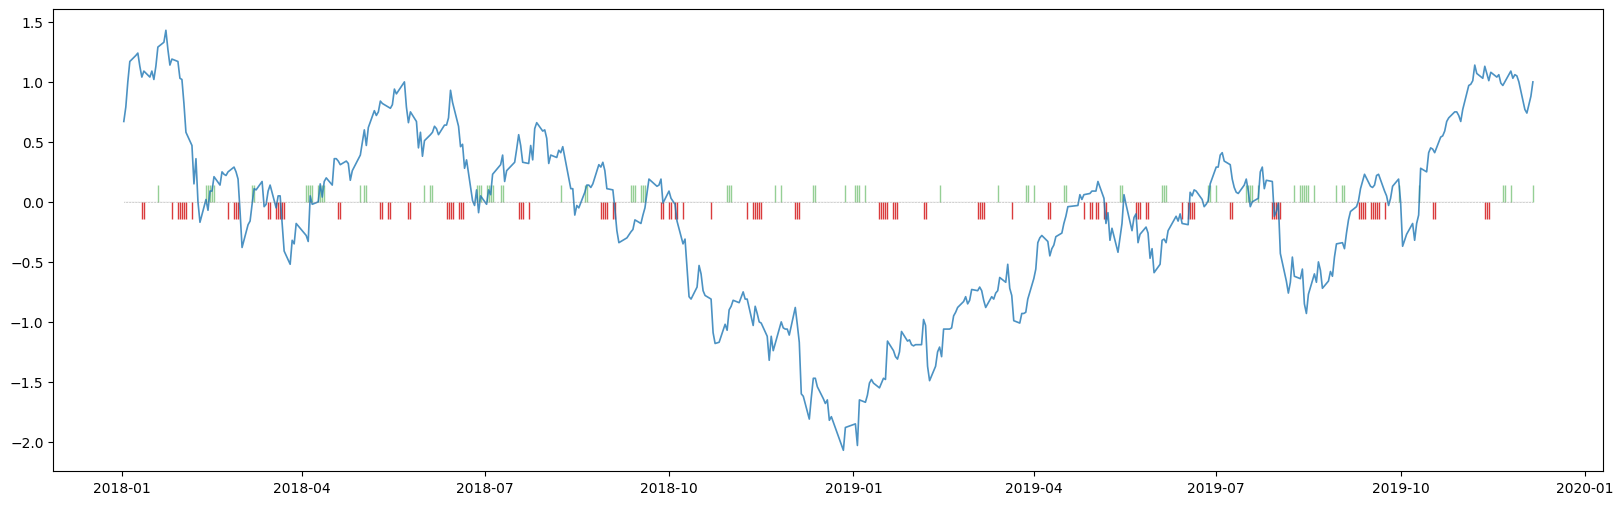

In [19]:
plot_marks(ticks.data, signal="close", marks="gmf_mono")

# Computation of the GMF signal

In [20]:
close = ticks.data.close.values
returns = ticks.data.returns.values
mf = ticks.data.med_filter.values
change = ticks.data.change.values

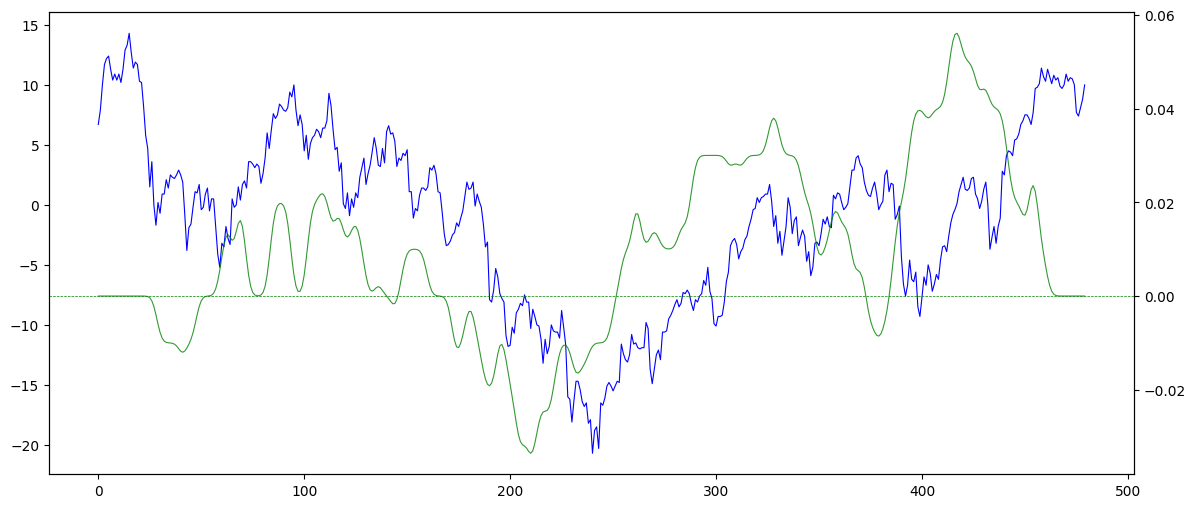

In [21]:
dual_plot((close * 10.0), medfilt(change, 51), smoothed=True)

Es interesante ver cómo cuando se acumulan $n$ días en los que la diferencia es positiva, se podría decir que se entra en un ciclo de tendencia positiva.

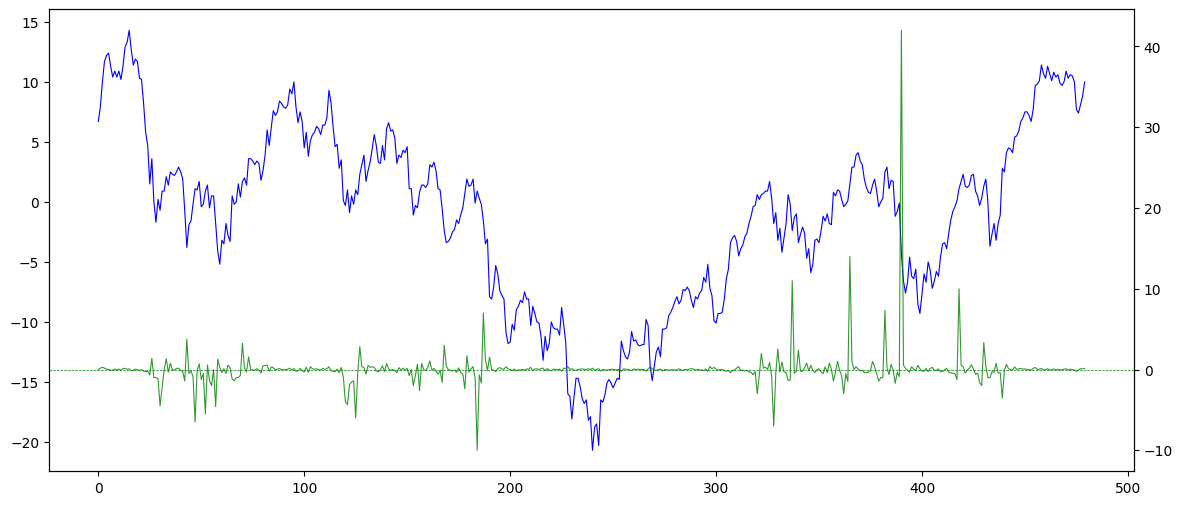

In [22]:
dual_plot(close * 10.0, returns)

Este plot también se podría utilizar para tener en cuenta que cuando la varianza de la señal se empieza a oscilar, o tiene picos grandes, anticipan bajadas. 

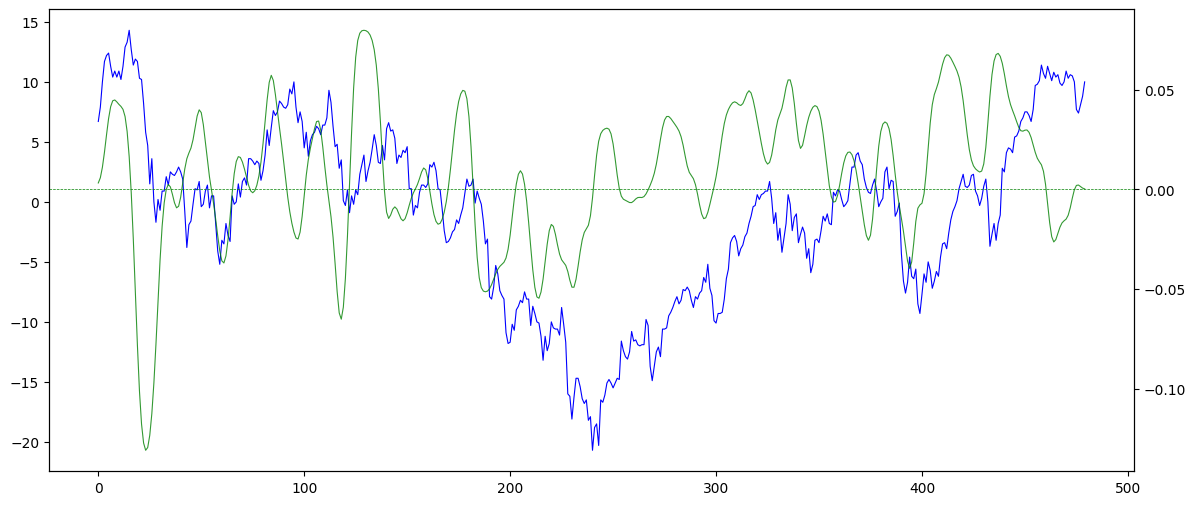

In [23]:
dual_plot((close * 10.0), medfilt(change, 11), True)

Con este tamaño de ventana, sólo se debería invertir al alza cuando la gausiana del filtro de medianas, sea positivo.

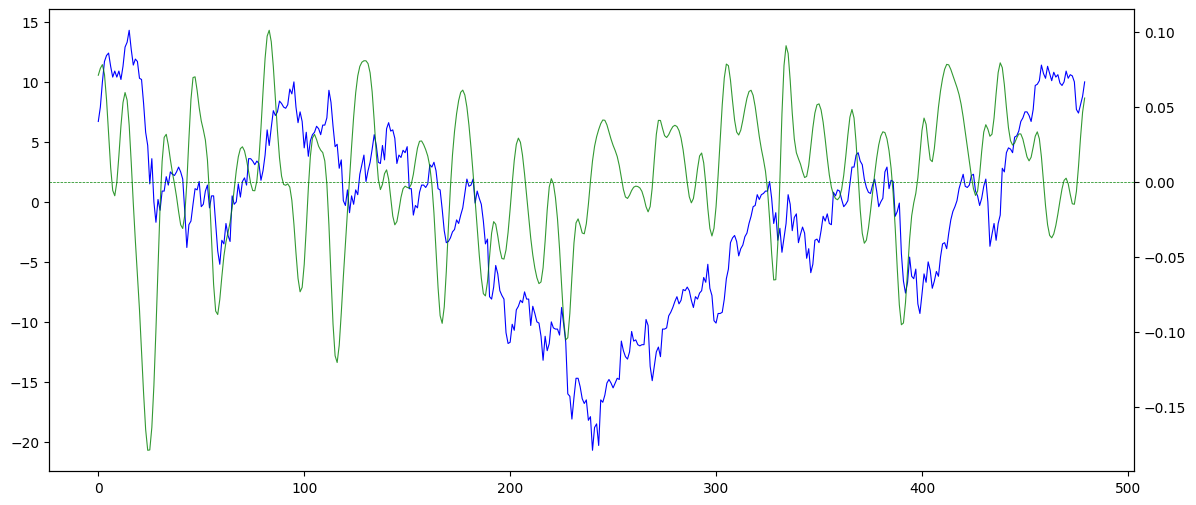

In [24]:
dual_plot((close * 10.0), medfilt(change, 5), True)

Construyo una funcion (`get_signal`) para saber cuando $n$ valores son monotonamente crecientes o decrecientes, sobre un período dado.

In [25]:
mf_change_5 = pd.Series(smooth(medfilt(change, 5)))
in_signal = get_positive_periods(mf_change_5, 5)
out_signal = get_negative_periods(mf_change_5, 5)
n = 200

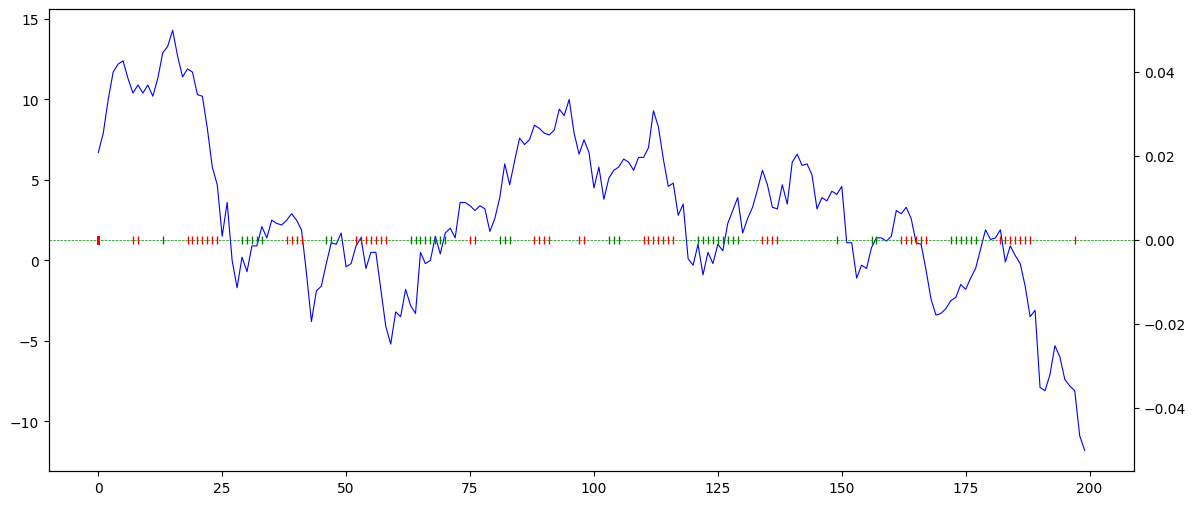

In [26]:
dual_plot(
    x1=(close * 10.0)[:n],
    x2=None,  # mf_change_5[:n],
    pos_marks=in_signal[:n],
    neg_marks=out_signal[:n],
)

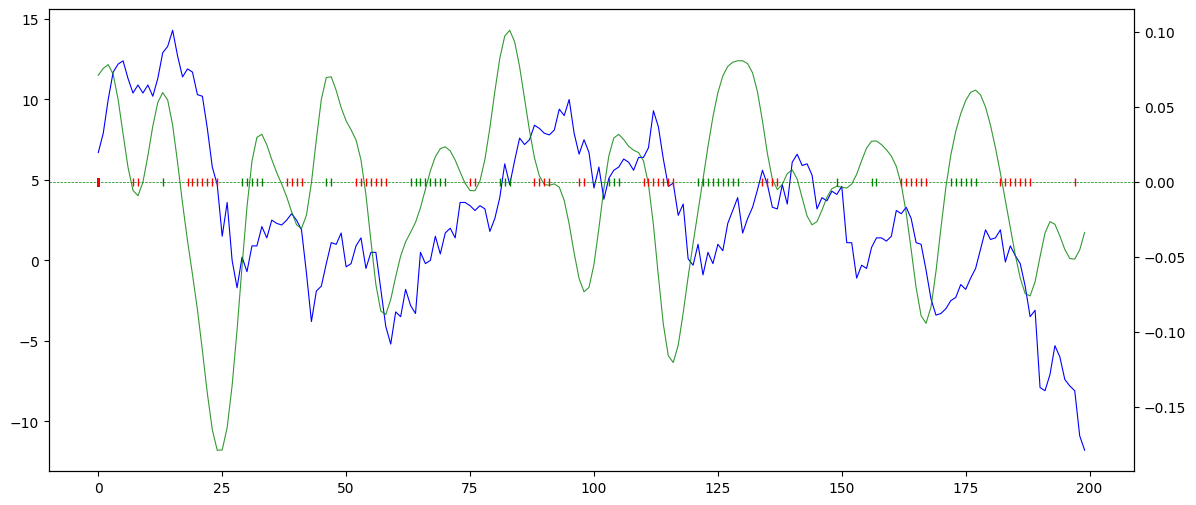

In [27]:
dual_plot(
    x1=(close * 10.0)[:n],
    x2=mf_change_5[:n],
    pos_marks=in_signal[:n],
    neg_marks=out_signal[:n],
)

--

# EUR USD

--

In [28]:
argv = [
    "",
    "-c",
    "../params/params.eurusd.yaml",
    "-f",
    "../data/EURUSD/EURUSD_2018_2020.csv",
    "--window",
    "8",
    "--epochs",
    "200",
    "train",
]
params = Dictionary(args=argv)

ticks = Ticks(params, params.input_file).scale()
ticks.append_indicator(["trend", "median_filter", "change"])
ticks.append_indicator("gmf", monotonic_window=7, mf_window=3, sigma=5)
ticks.append_indicator("gmf_mono", monotonic_window=7, mf_window=3, sigma=5)

close = ticks.data.close.values
returns = ticks.data.returns.values
mf = ticks.data.med_filter.values
change = ticks.data.change.values

2020-11-13 12:28:28 - INFO  - Dictionary:__init__               - Using configuration parameters from: ../params/params.eurusd.yaml


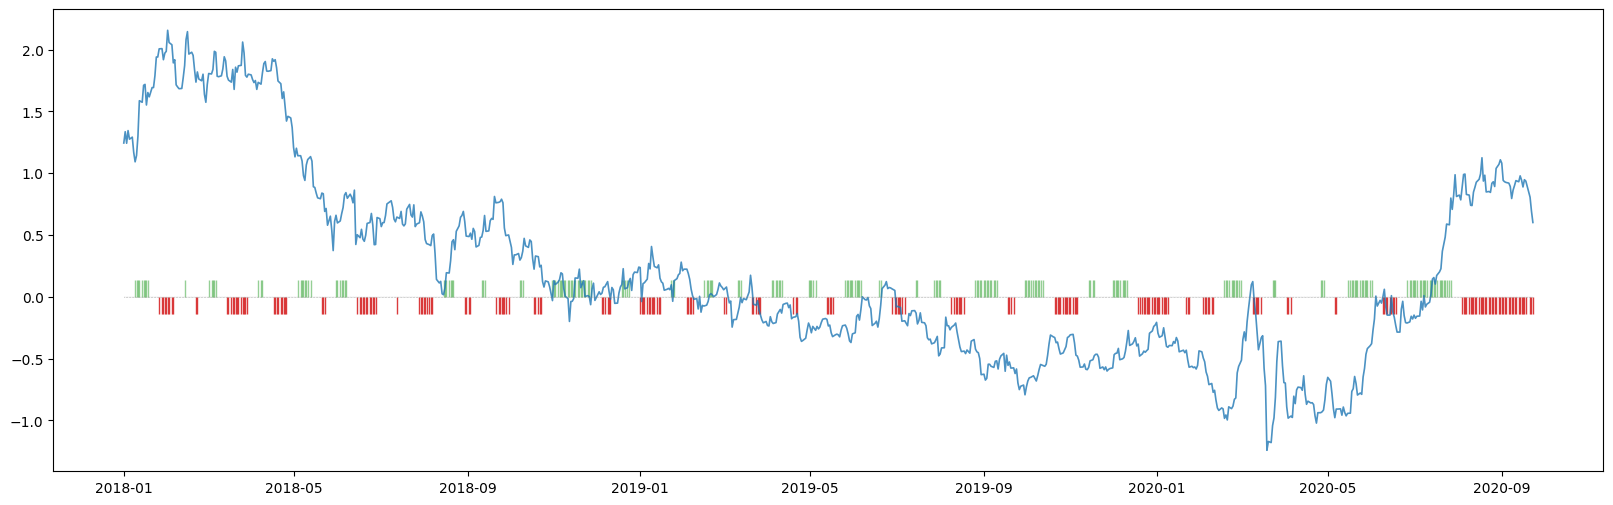

In [29]:
plot_marks(ticks.data, signal="close", marks="gmf_mono")

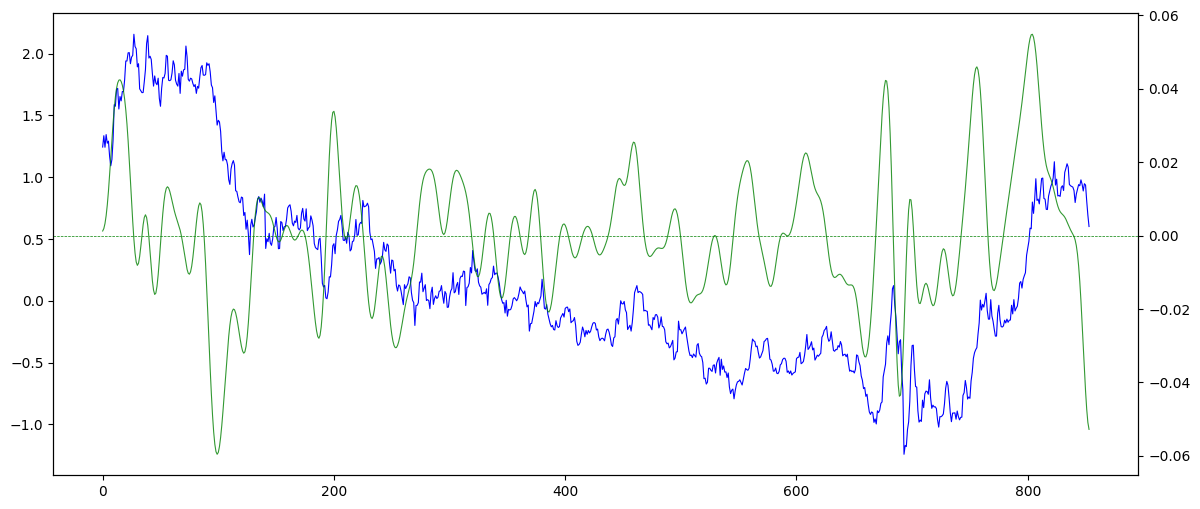

In [30]:
dual_plot((close), medfilt(change, 3), True, sigma=5)

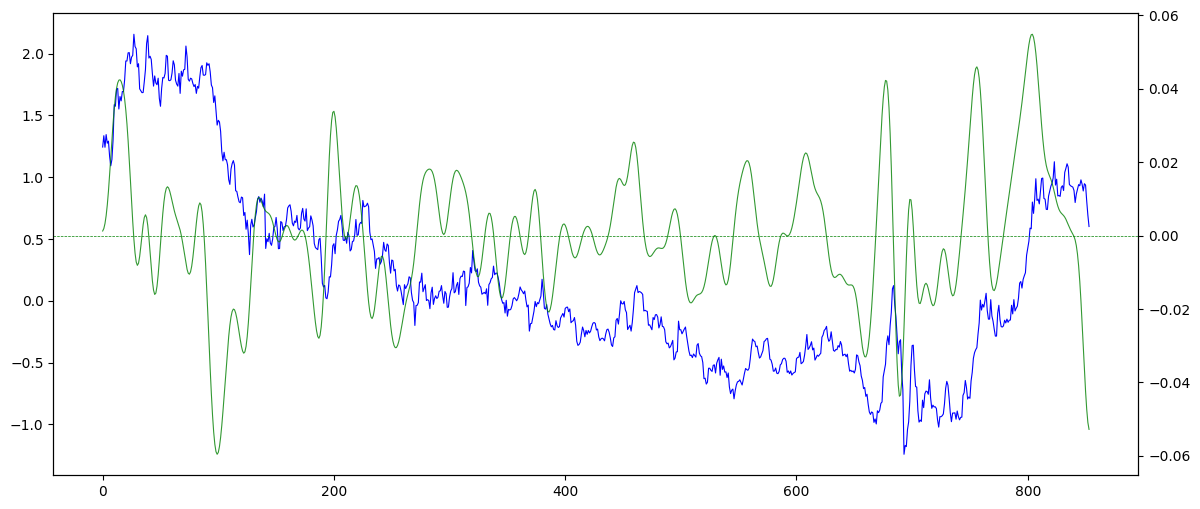

In [31]:
dual_plot((close), medfilt(change, 3), True, sigma=5)

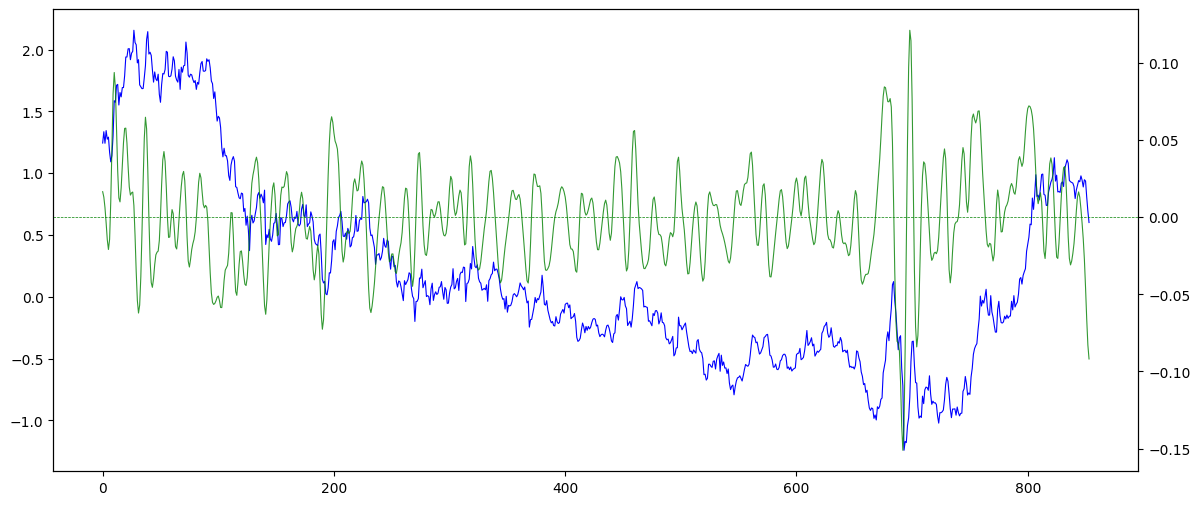

In [32]:
dual_plot((close), change, True)

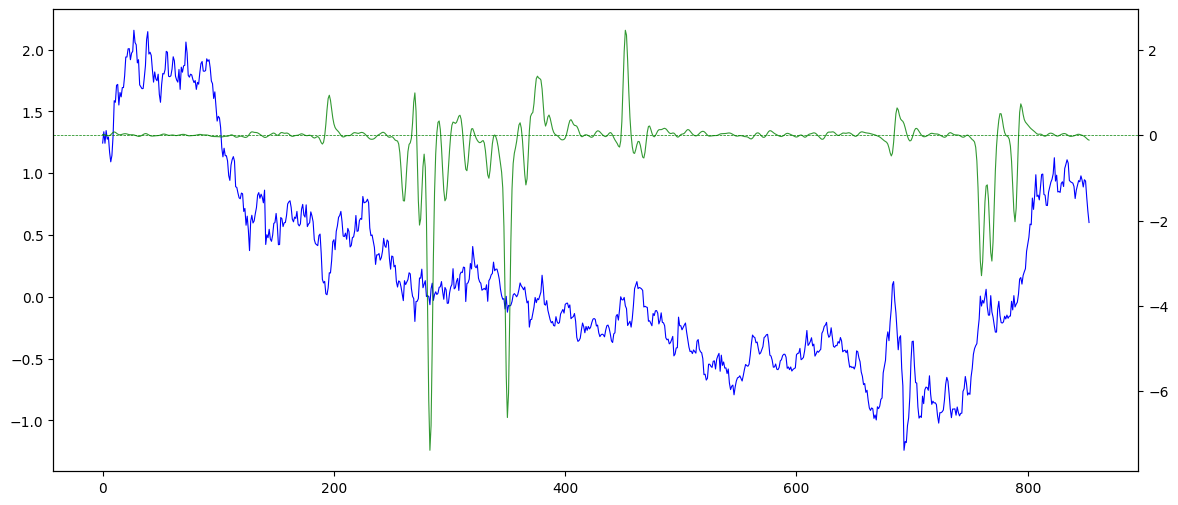

In [33]:
dual_plot((close), returns, True)

# Try shorter windows

I try to check if my new signal will work with up-to-today data. I plot 15 values of the actual signal, together with the resulting median filter for the whole set. After that I simply consider different windows of the true signal, to compute the median filter or the gaussian with a shorter window of data, to check how much it deviates from the actual values.

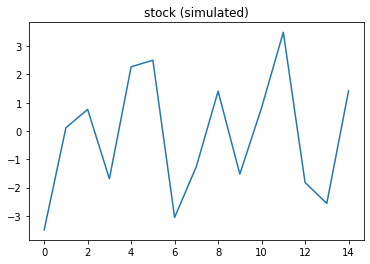

In [55]:
def f(x):
    return -np.cos(x) - np.sin(x) - (5 / 2) * np.cos(2 * x) + (1 / 2) * np.sin(2 * x)


X = np.arange(15.0)
s = pd.DataFrame({"x1": X, "x2": [f(x) for x in X]})

plt.plot(s.x2)
plt.title("stock (simulated)")
plt.show()

Plotting the MF with the data available ONLY up to a certain day (starting at 8th day, up to 13th), the result is that MF with partial data doesn't match the MF computed over the entire series of data, but deviates not too much. In a real life scenario, this shorter window can be extended with the forecast value of the signal for the next day to get a more accurate approximation of the MF signal.

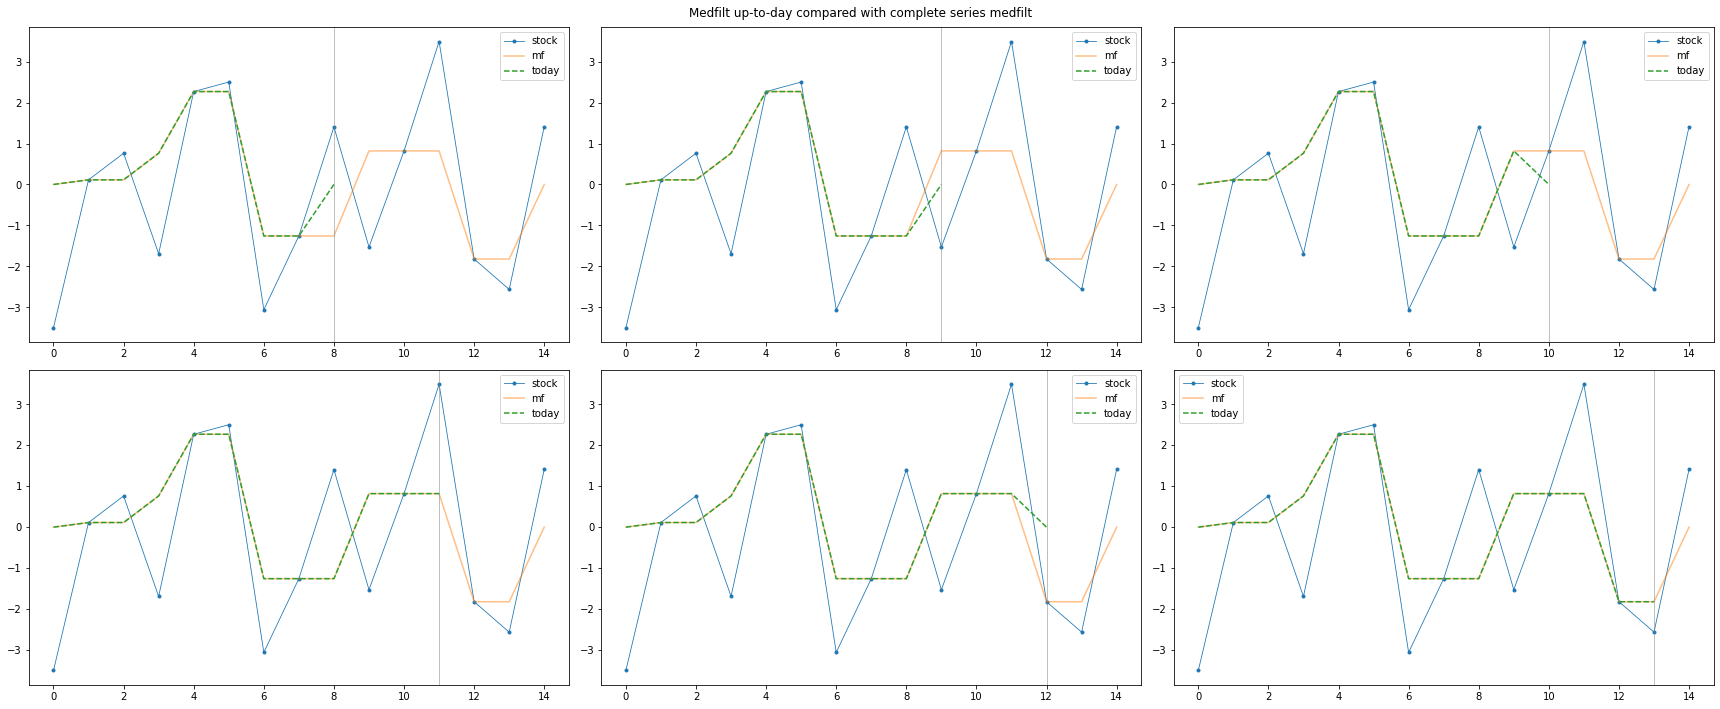

In [61]:
fig, ax = plt.subplots(nrows=2, ncols=3)
fig.set_size_inches(24, 10)
w_size = 9
for row in range(2):
    for column in range(3):
        ax[row, column].plot(s.x2, linewidth=0.8, marker=".", label="stock")
        ax[row, column].plot(medfilt(s.x2, kernel_size=3), alpha=0.5, label="mf")
        ax[row, column].plot(
            medfilt(s.x2[:w_size], kernel_size=3), linestyle="dashed", label="today"
        )
        ax[row, column].axvline(w_size - 1, linewidth=0.5, color="grey")
        ax[row, column].legend()
        w_size += 1

fig.suptitle("Medfilt up-to-day compared with complete series medfilt")
plt.tight_layout()
plt.show()

Gaussian filtered signal computed over the stretched up-to-day window suffers the same deviation, as it is computed over the shorter MF signal. By using forecast we could get a more accurate version of the Gaussian1d filter, given that the forecast is correct.

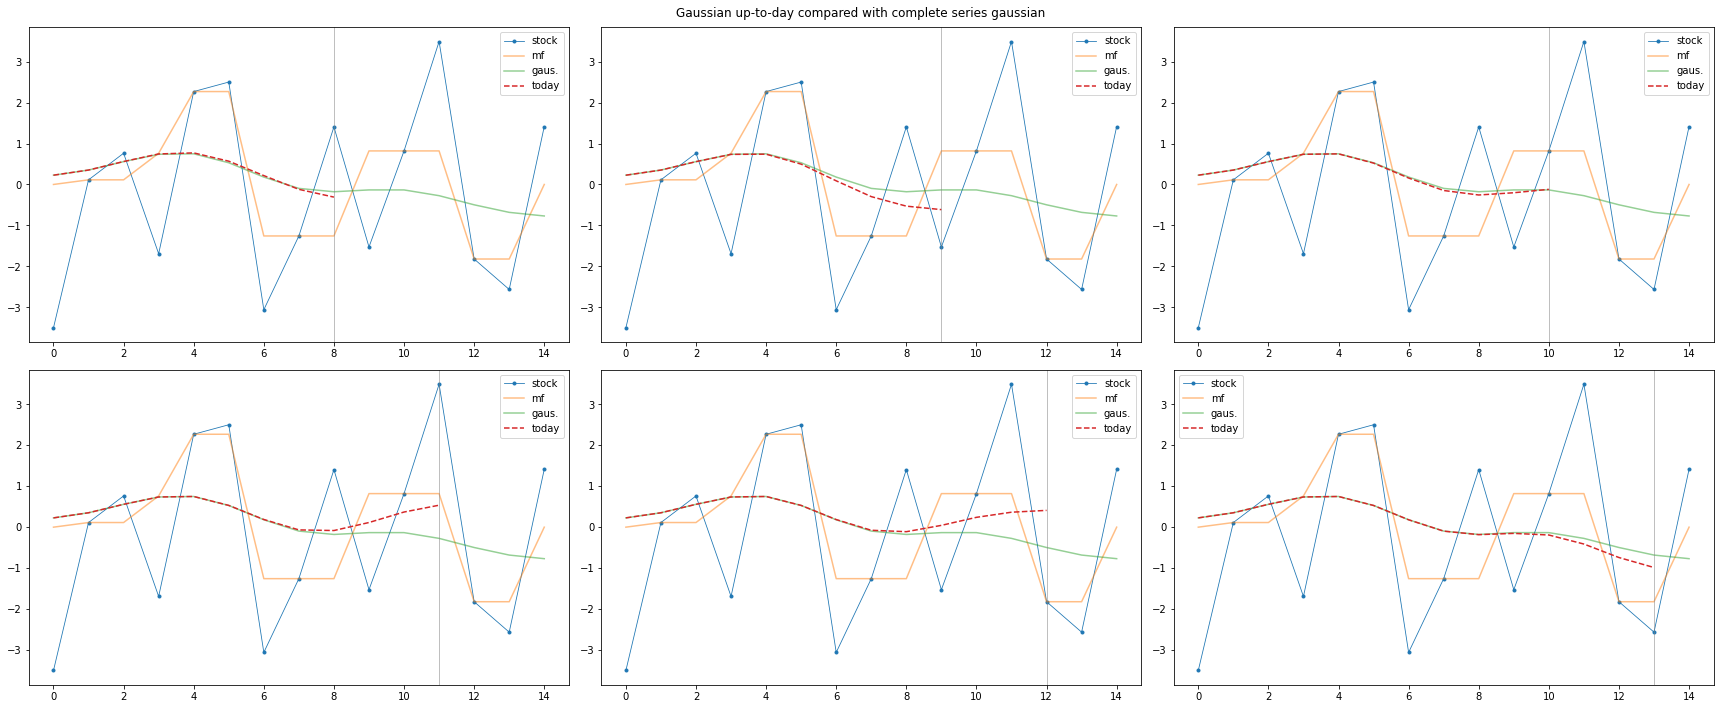

In [60]:
fig, ax = plt.subplots(nrows=2, ncols=3)
fig.set_size_inches(24, 10)
w_size = 9
for row in range(2):
    for column in range(3):
        ax[row, column].plot(s.x2, linewidth=0.8, marker=".", label="stock")
        ax[row, column].plot(
            medfilt(s.x2, kernel_size=3), alpha=0.5, label="mf",
        )
        ax[row, column].plot(
            gaussian_filter1d(medfilt(s.x2, kernel_size=3), sigma=2),
            alpha=0.5,
            label="gaus.",
        )
        ax[row, column].plot(
            gaussian_filter1d(medfilt(s.x2[:w_size], kernel_size=3), sigma=2),
            linestyle="dashed",
            label="today",
        )
        ax[row, column].axvline(w_size - 1, linewidth=0.5, color="grey")
        w_size += 1
        ax[row, column].legend()

fig.suptitle("Gaussian up-to-day compared with complete series gaussian")
plt.tight_layout()
plt.show()